In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pip install pystoi

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pesq

  Preparing metadata (setup.py) ... - \ done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=114934 sha256=97275f083a1acc10d303edddf713c8610e97c297a1f3f64ba72e6997b751dd11
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq
Note: you may need to restart the kernel to use updated packages.


In [4]:
class SpeechDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, sample_rate=16000, segment_length=16000):
        super(SpeechDataset, self).__init__()
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.sample_rate = sample_rate
        self.segment_length = segment_length

        self.clean_files = sorted([
            f for f in os.listdir(clean_dir)
            if os.path.isfile(os.path.join(clean_dir, f))
        ])
        self.noisy_files = sorted([
            f for f in os.listdir(noisy_dir)
            if os.path.isfile(os.path.join(noisy_dir, f))
        ])

        assert len(self.clean_files) == len(self.noisy_files), \
            f"Number of clean files ({len(self.clean_files)}) does not match number of noisy files ({len(self.noisy_files)})."

        for clean_file, noisy_file in zip(self.clean_files, self.noisy_files):
            assert clean_file == noisy_file, \
                f"Filename mismatch: {clean_file} and {noisy_file}"

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        filename = self.clean_files[idx]
        clean_path = os.path.join(self.clean_dir, filename)
        noisy_path = os.path.join(self.noisy_dir, filename)

        clean, _ = librosa.load(clean_path, sr=self.sample_rate)
        noisy, _ = librosa.load(noisy_path, sr=self.sample_rate)

        min_len = min(len(clean), len(noisy))
        clean = clean[:min_len]
        noisy = noisy[:min_len]

        if len(clean) < self.segment_length:
            pad_width = self.segment_length - len(clean)
            clean = np.pad(clean, (0, pad_width), 'constant')
            noisy = np.pad(noisy, (0, pad_width), 'constant')
        else:
            start = np.random.randint(0, len(clean) - self.segment_length + 1)
            clean = clean[start:start + self.segment_length]
            noisy = noisy[start:start + self.segment_length]

        clean = torch.from_numpy(clean).float().unsqueeze(0)
        noisy = torch.from_numpy(noisy).float().unsqueeze(0)

        return noisy, clean


In [5]:
clean_train_dir = '/kaggle/input/voicebank-demand-16k/clean_trainset_28spk_wav'
noisy_train_dir = '/kaggle/input/voicebank-demand-16k/noisy_trainset_28spk_wav'
clean_test_dir = '/kaggle/input/voicebank-demand-16k/clean_testset_wav'
noisy_test_dir = '/kaggle/input/voicebank-demand-16k/noisy_testset_wav'

In [6]:
train_dataset = SpeechDataset(clean_dir=clean_train_dir, noisy_dir=noisy_train_dir)
test_dataset = SpeechDataset(clean_dir=clean_test_dir, noisy_dir=noisy_test_dir)

In [7]:
batch_size = 16
val_size = int(0.5 * len(test_dataset)) 
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)


In [8]:
class Generator(nn.Module):
    def __init__(self, noise_channels=1, output_channels=1, feature_maps=64):
        super(Generator, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(noise_channels, feature_maps, kernel_size=15, stride=1, padding=7),
            nn.BatchNorm1d(feature_maps),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(feature_maps, feature_maps*2, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(feature_maps*2, feature_maps*4, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv1d(feature_maps*4, feature_maps*8, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(feature_maps*8, feature_maps*4, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.BatchNorm1d(feature_maps*4),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(feature_maps*8, feature_maps*2, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.BatchNorm1d(feature_maps*2),
            nn.ReLU(inplace=True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose1d(feature_maps*4, feature_maps, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.BatchNorm1d(feature_maps),
            nn.ReLU(inplace=True)
        )
        self.decoder4 = nn.Sequential(
            nn.Conv1d(feature_maps*2, output_channels, kernel_size=15, stride=1, padding=7),
            nn.Tanh()
        )

        # Initialize weights
        self.apply(self.weights_init)

    def forward(self, x):
        enc1 = self.encoder1(x)  
        enc2 = self.encoder2(enc1)  
        enc3 = self.encoder3(enc2)  
        enc4 = self.encoder4(enc3)  

        dec1 = self.decoder1(enc4)  
        dec1 = torch.cat((dec1, enc3), dim=1)  

        dec2 = self.decoder2(dec1)  
        dec2 = torch.cat((dec2, enc2), dim=1)  

        dec3 = self.decoder3(dec2)  
        dec3 = torch.cat((dec3, enc1), dim=1)  

        dec4 = self.decoder4(dec3) 

        return dec4

    def weights_init(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1, feature_maps=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, feature_maps, kernel_size=15, stride=1, padding=7),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(feature_maps, feature_maps*2, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(feature_maps*2, feature_maps*4, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(feature_maps*4, feature_maps*8, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(feature_maps*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(feature_maps*8, 1, kernel_size=15, stride=1, padding=7),
            nn.Sigmoid()
        )

        self.apply(self.weights_init)

    def forward(self, x):
        return self.model(x).view(-1, 1)  # Flatten output

    def weights_init(self, m):
        """Initializes weights with a normal distribution."""
        if isinstance(m, nn.Conv1d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss().to(device)
l1_loss = nn.L1Loss().to(device)

num_epochs = 10
lambda_l1 = 100  

In [12]:
import numpy as np
from pystoi import stoi
from pesq import pesq

def denormalize_audio(tensor):
    return tensor.cpu().numpy()

def calculate_snr(clean, denoised):
    
    noise = clean - denoised
    signal_power = np.sum(clean ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def evaluate(generator, val_loader):
    generator.eval()
    stoi_scores = []
    pesq_scores = []
    snr_scores = []
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            denoised = generator(noisy)

            clean_np = denormalize_audio(clean.squeeze(1))  
            denoised_np = denormalize_audio(denoised.squeeze(1))  

            for c, d in zip(clean_np, denoised_np):
                if len(c) < 256 or len(d) < 256:
                    print("Skipping short audio segment.")
                    continue
                if np.allclose(c, 0) or np.allclose(d, 0):
                    print("Skipping silent audio segment.")
                    continue
                c = np.clip(c / np.max(np.abs(c)), -1, 1)
                d = np.clip(d / np.max(np.abs(d)), -1, 1)

                stoi_score = stoi(c, d, 16000) 
                stoi_scores.append(stoi_score)

                try:
                    pesq_score = pesq(16000, c, d, mode="wb")  
                    pesq_scores.append(pesq_score)
                except Exception as e:
                    continue

                snr_score = calculate_snr(c, d)
                snr_scores.append(snr_score)

    avg_stoi = np.mean(stoi_scores) if stoi_scores else 0
    avg_pesq = np.mean(pesq_scores) if pesq_scores else 0
    avg_snr = np.mean(snr_scores) if snr_scores else 0
    return avg_stoi, avg_pesq, avg_snr



In [13]:
generator_state_dict = torch.load('/kaggle/input/segan-checkpoints/checkpoints/generator_epoch_10.pth')
discriminator_state_dict = torch.load('/kaggle/input/segan-checkpoints/checkpoints/discriminator_epoch_10.pth')

generator.load_state_dict(generator_state_dict)
discriminator.load_state_dict(discriminator_state_dict)

/tmp/ipykernel_23/3602705950.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state_dict = torch.load('/kaggle/input/segan-checkpoints/checkpoints/generator_epo

<All keys matched successfully>

In [14]:
generator_losses = []
discriminator_losses = []
epochs = []

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    epoch_gen_loss = 0
    epoch_dis_loss = 0

    for i, (noisy, clean) in enumerate(train_loader):
        noisy = noisy.to(device)  
        clean = clean.to(device)  

        batch_size_current = noisy.size(0)
        
        optimizer_G.zero_grad()
        denoised = generator(noisy)
        pred_fake = discriminator(denoised)

        valid = torch.ones_like(pred_fake).to(device)
        fake = torch.zeros_like(pred_fake).to(device)

        loss_G_adv = adversarial_loss(pred_fake, valid)
        loss_G_l1 = l1_loss(denoised, clean)
        loss_G = loss_G_adv + lambda_l1 * loss_G_l1
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = discriminator(clean)
        loss_D_real = adversarial_loss(pred_real, valid)

        pred_fake = discriminator(denoised.detach())
        loss_D_fake = adversarial_loss(pred_fake, fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        epoch_gen_loss += loss_G.item()
        epoch_dis_loss += loss_D.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch+11}/{num_epochs+10}] Batch [{i}/{len(train_loader)}] "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    avg_gen_loss = epoch_gen_loss / len(train_loader)
    avg_dis_loss = epoch_dis_loss / len(train_loader)
    
    generator_losses.append(avg_gen_loss)
    discriminator_losses.append(avg_dis_loss)
    epochs.append(epoch + 11)  

    avg_stoi, avg_pesq, avg_snr = evaluate(generator, val_loader)
    print(f"Epoch [{epoch+11}/{num_epochs+10}] Validation - STOI: {avg_stoi:.4f}, PESQ: {avg_pesq:.4f}, SNR: {avg_snr:.4f}")
   
    if (epoch + 1) % 2 == 0:
        checkpoint_dir = 'checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch+11}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+11}.pth"))
        print(f"Saved model checkpoints for epoch {epoch+1}.")

    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")


Epoch [11/20] Batch [0/724] Loss D: 0.0034, Loss G: 9.6226
Epoch [11/20] Batch [100/724] Loss D: 0.0009, Loss G: 8.6486
Epoch [11/20] Batch [200/724] Loss D: 0.0002, Loss G: 13.4758
Epoch [11/20] Batch [300/724] Loss D: 0.0003, Loss G: 10.0713
Epoch [11/20] Batch [400/724] Loss D: 0.0003, Loss G: 10.2551
Epoch [11/20] Batch [500/724] Loss D: 0.0002, Loss G: 12.6755
Epoch [11/20] Batch [600/724] Loss D: 0.0002, Loss G: 10.4064
Epoch [11/20] Batch [700/724] Loss D: 0.0003, Loss G: 10.1838
Epoch [11/20] Validation - STOI: 0.9252, PESQ: 1.5632, SNR: 10.0618
Epoch [1/10] completed.
Epoch [12/20] Batch [0/724] Loss D: 0.0002, Loss G: 10.8398
Epoch [12/20] Batch [100/724] Loss D: 0.0001, Loss G: 11.5913
Epoch [12/20] Batch [200/724] Loss D: 0.0015, Loss G: 10.6394
Epoch [12/20] Batch [300/724] Loss D: 0.0009, Loss G: 9.4645
Epoch [12/20] Batch [400/724] Loss D: 0.0008, Loss G: 9.6343
Epoch [12/20] Batch [500/724] Loss D: 0.0004, Loss G: 9.7515
Epoch [12/20] Batch [600/724] Loss D: 0.0005, Los

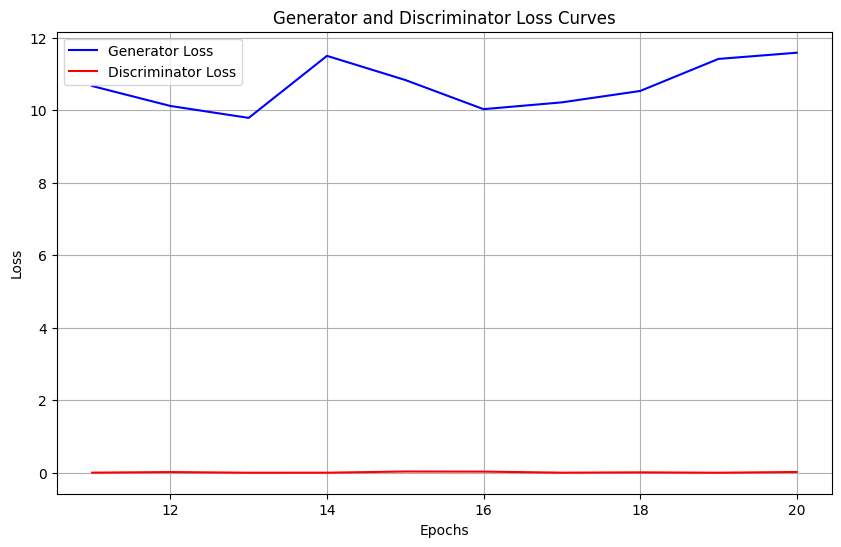

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, generator_losses, label="Generator Loss", color='blue')
plt.plot(epochs, discriminator_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
avg_stoi, avg_pesq , avg_snr = evaluate(generator, test_loader)

In [17]:
print(f" Test Set - STOI: {avg_stoi:.4f}, PESQ: {avg_pesq:.4f}, SNR: {avg_snr:.4f}")

 Test Set - STOI: 0.9039, PESQ: 1.5810, SNR: 8.4935
